# Project #3 — Diabetes Prediction with XGBoost and API Deployment
- **Author:** Isabel Ekwenibe  
- **GitHub Repository Link:** https://github.com/ne00040/Diabetes-Prediction-XGBoost-Deployment 
- **Video for Project 3:** [Add Loom or YouTube link here after recording]  


## 1. Problem Statement
This project extends the fundamentals learned in class by introducing a new prediction algorithm, **XGBoost**, and applying it to a real-world dataset.  
The goal is to predict whether an individual is likely to develop or has been diagnosed with diabetes based on demographic, lifestyle, and clinical factors.  
Finally, the best-performing model is deployed as a **RESTful API** with a user-friendly interface.


## 2. Dataset Overview
- **Total Records:** 100,000  
- **Total Features:** 31  
- **Feature Categories:**
  - **Demographic:** `age`, `gender`, `ethnicity`, `education_level`, `income_level`
  - **Lifestyle:** `physical_activity`, `smoking_status`, `diet_score`
  - **Clinical:** `bmi`, `blood_pressure`, `cholesterol`, `glucose_level`, `insulin_sensitivity`, `diabetes_risk_score`, `diabetes_stage`


## 3. Target Variable — `diagnosed_diabetes`
- **Type:** Binary classification  
- **Values:**
  - `1` → Diagnosed with diabetes  
  - `0` → Not diagnosed  


## 4. Prediction Goal
Build and evaluate a **classification model** that predicts whether a person is **diagnosed with diabetes** (`1`) or **not** (`0`) based on their **health and lifestyle indicators**.  
Compare the performance of **XGBoost** with **Logistic Regression**, and deploy the best model as a RESTful API.

In [51]:
## 1. Load and Preprocess Dataset

import pandas as pd
import numpy as np

# Load dataset
df = pd.read_csv("diabetes_dataset.csv")
print("Original dataset shape:", df.shape)

# Drop leakage features
leakage_features = ['diabetes_risk_score', 'diabetes_stage', 'hba1c']
df = df.drop(columns=[col for col in leakage_features if col in df.columns], errors='ignore')
print("\nColumns after dropping leakage features:")
print(df.columns.tolist())

# Handle missing values
df = df.dropna()
print("\nShape after dropping missing values:", df.shape)

# Separate features and target
X = df.drop(columns=['diagnosed_diabetes'])
y = df['diagnosed_diabetes']

# One-hot encode categorical variables
X = pd.get_dummies(X, drop_first=True)
print("\nShape after one-hot encoding:", X.shape)

# Scale numeric features
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
print("\nFeature scaling completed.")

Original dataset shape: (100000, 31)

Columns after dropping leakage features:
['age', 'gender', 'ethnicity', 'education_level', 'income_level', 'employment_status', 'smoking_status', 'alcohol_consumption_per_week', 'physical_activity_minutes_per_week', 'diet_score', 'sleep_hours_per_day', 'screen_time_hours_per_day', 'family_history_diabetes', 'hypertension_history', 'cardiovascular_history', 'bmi', 'waist_to_hip_ratio', 'systolic_bp', 'diastolic_bp', 'heart_rate', 'cholesterol_total', 'hdl_cholesterol', 'ldl_cholesterol', 'triglycerides', 'glucose_fasting', 'glucose_postprandial', 'insulin_level', 'diagnosed_diabetes']

Shape after dropping missing values: (100000, 28)

Shape after one-hot encoding: (100000, 39)

Feature scaling completed.


### Summary
  We load the diabetes dataset, removes leakage features to prevent overfitting, handles missing values, separates features and target, applies one-hot encoding to categorical variables, and scales numeric features using MinMaxScaler. These steps ensure the data is clean and ready for modeling.

In [52]:
## 2. Split Data into Training and Testing Sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

Training set shape: (80000, 39)
Testing set shape: (20000, 39)


In [53]:
## 3. Train Logistic Regression Model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

log_reg = LogisticRegression(max_iter=1000, solver='liblinear')
log_reg.fit(X_train, y_train)

# Predictions
y_pred_lr = log_reg.predict(X_test)
y_prob_lr = log_reg.predict_proba(X_test)[:, 1]

# Evaluation Metrics
lr_metrics = {
    'Accuracy': accuracy_score(y_test, y_pred_lr),
    'Precision': precision_score(y_test, y_pred_lr),
    'Recall': recall_score(y_test, y_pred_lr),
    'F1 Score': f1_score(y_test, y_pred_lr),
    'ROC-AUC': roc_auc_score(y_test, y_prob_lr)
}

print("\nLogistic Regression Performance:")
for metric, value in lr_metrics.items():
    print(f"{metric}: {value:.3f}")


Logistic Regression Performance:
Accuracy: 0.832
Precision: 0.848
Recall: 0.876
F1 Score: 0.862
ROC-AUC: 0.910


### Summary
We train a Logistic Regression model as a baseline and evaluates its performance using key metrics: Accuracy, Precision, Recall, F1 Score, and ROC-AUC.

In [54]:
## 4. Train XGBoost Model
import xgboost as xgb

xgb_model = xgb.XGBClassifier(eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

# Predictions
y_pred_xgb = xgb_model.predict(X_test)
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Evaluation Metrics
xgb_metrics = {
    'Accuracy': accuracy_score(y_test, y_pred_xgb),
    'Precision': precision_score(y_test, y_pred_xgb),
    'Recall': recall_score(y_test, y_pred_xgb),
    'F1 Score': f1_score(y_test, y_pred_xgb),
    'ROC-AUC': roc_auc_score(y_test, y_prob_xgb)
}

print("\nXGBoost Performance:")
for metric, value in xgb_metrics.items():
    print(f"{metric}: {value:.3f}")


XGBoost Performance:
Accuracy: 0.842
Precision: 0.900
Recall: 0.829
F1 Score: 0.863
ROC-AUC: 0.912


### Summary
We train the XGBoost model on the same dataset and evaluates its performance using the same metrics. XGBoost is expected to outperform Logistic Regression due to its advanced boosting technique.

In [55]:
## 5. Compare Model Performance
comparison_df = pd.DataFrame([lr_metrics, xgb_metrics], index=['Logistic Regression', 'XGBoost'])
print("\nModel Performance Comparison:")
print(comparison_df)


Model Performance Comparison:
                     Accuracy  Precision    Recall  F1 Score   ROC-AUC
Logistic Regression   0.83175   0.848326  0.876250  0.862062  0.910119
XGBoost               0.84180   0.899819  0.828583  0.862733  0.911772


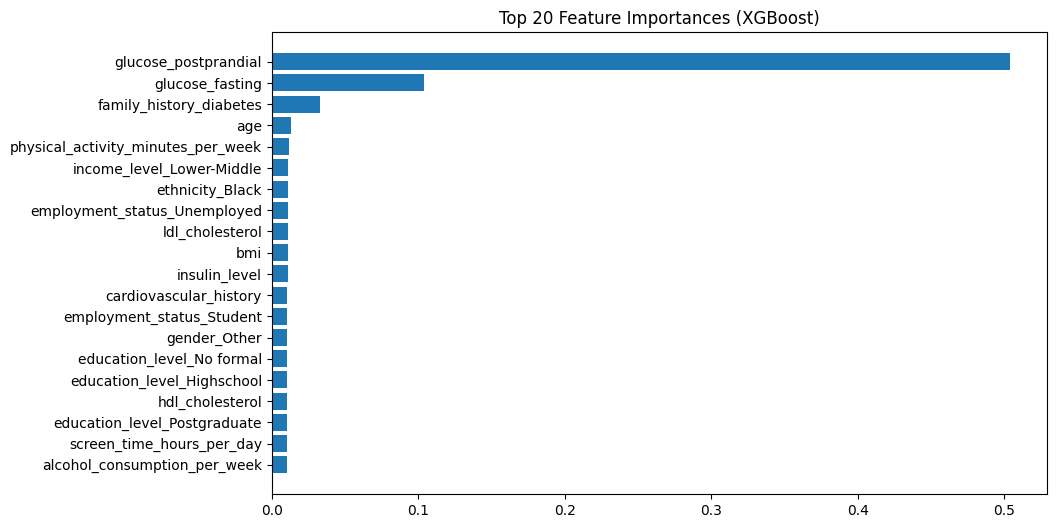

In [56]:
## 6. Visualize Feature Importance (Top 20 Features)
import matplotlib.pyplot as plt

importance = xgb_model.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importance}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'].head(20), importance_df['Importance'].head(20))
plt.title("Top 20 Feature Importances (XGBoost)")
plt.gca().invert_yaxis()
plt.show()

### Summary
The top 20 most important features according to the XGBoost model is visualized. It provides interpretability by showing which factors contribute most to diabetes prediction.

In [57]:
## 7. Save Best Model and Scaler for Deployment
import joblib

best_model = xgb_model if xgb_metrics['Accuracy'] > lr_metrics['Accuracy'] else log_reg
joblib.dump(best_model, 'best_diabetes_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

print("\nBest model saved as 'best_diabetes_model.pkl' and scaler saved as 'scaler.pkl'.")


Best model saved as 'best_diabetes_model.pkl' and scaler saved as 'scaler.pkl'.


### Summary
We save the best-performing model (XGBoost or Logistic Regression) and the scaler for deployment. These files will be used in the Flask API for real-time predictions.